In [891]:
#Install textstat module
#!pip install textstat
#Download nltk. if needed
#import nltk
#nltk.download()

In [870]:
#RUN TIME: ~3min
import pandas as pd
import pickle
import matplotlib.pyplot as plt
# This is the method to make sure that plots appear directly in the notebook
%matplotlib inline
import numpy as np
import scipy.stats as stat

#Load dialog data
df_dialog = pd.read_table(
    './movie-dialog-corpus/movie_lines.txt',
    delimiter='\t',
    error_bad_lines=False,
    warn_bad_lines=False,
    header=None,
    names=[
        'lineID',
        'characterID',
        'movieID',
        'character_name',
        'dialog'
    ]
)

# Select only data with a valid dialog
df_dialog = df_dialog[(df_dialog.character_name.notnull()) & (df_dialog.dialog.notnull())]

#Load character data
df_character = pd.read_table(
    './movie-dialog-corpus/movie_characters_metadata.txt',
    delimiter='\t',
    header=None,
    names=[
        'characterID',
        'character_name',
        'movieID',
        'movie_title',
        'gender',
        'position_in_credits'
    ]
)

#Eliminate duplicate:
#df_dialog = df[df.name != 'Tina']

#load movie title data
with open('./movie-dialog-corpus/movie_title.pkl', 'rb') as f:
    df_title = pickle.load(f)

df_title.drop(['genres_x', 'movie_title'], axis='columns', inplace=True)
df_title.rename({'genres_y' : 'genres', 'title' : 'movie_title'}, axis='columns', inplace=True)

# add release month
def parse_month(x):
    if type(x) is str:
        return np.int8(x[5:7])
    return np.nan

df_title['release_month'] = df_title.release_date.apply(parse_month)


In [871]:
#Functions to look at data 

#Function to see how many movies are per genres
def count_movie_genres():
 
    genre_dict = {}
    #Iterate over the movies in the title dataframe
    for i in range(len(df_title)):
        #Get list of genres
        lst_genre = df_title.iloc[i,5]
        if type(lst_genre) == list:
            #Separate genres and put them in a dictionary
            for genre in lst_genre:
                if genre in genre_dict:
                    genre_dict[genre] += 1
                else:
                    genre_dict[genre] = 1

    return genre_dict


#Function to count how many lines a character has.
#It is used later to calculate the polarization score
def count_characters_lines(movie_id):
    character_dict = {}
    character_id_dict = {}
    #Filter dialog dataframe to get only the relevant movie dialogue
    df_movie = df_dialog[df_dialog['movieID'] == movie_id]
    #Iterate over this dialogue
    for i in range(len(df_movie)):
        #Get two dictionaries with the character name or character id and his/her number of lines
        character_name = df_movie.iloc[i,3]
        character_id = df_movie.iloc[i,1]
        if character_name in character_dict:
            character_dict[character_name] += 1
            character_id_dict[character_id] += 1
        else:
            character_dict[character_name] = 1
            character_id_dict[character_id] = 1

    return character_dict, character_id_dict

#Dictionary with genres and number of movies within a genre
genre_dict = count_movie_genres()


In [872]:
#Function to get a dictionary of the movie ids and the movie titles within a genre
def extract_genre_dict(Genre):
    movie_ids = {}
    #Iterate over movies in title dataframe
    for i in range(len(df_title)):
        #Separate the movie title, movie id and genres of a dataframe row
        movie_title = df_title.iloc[i,18]
        lst_genre = df_title.iloc[i,5]
        movie_id = df_title.iloc[i,0]
        #Filter to get the ids and title of the movies in the genre
        if type(lst_genre) == list and Genre in lst_genre:
            movie_ids[movie_id] = movie_title
                
    return movie_ids  

#Function to get a dictionary of the genres and the movie ids of the movies within those genres
def genre_movie_dict():
    genre_movie_dict = {}
    #Iterate through genres
    for genre in genre_dict.keys():
        movie_lst = []
        #Get the dictionary of the movie titles and movie ids within a genre
        dct = extract_genre_dict(genre)
        #Iterate through movie ids
        for movies in dct.keys():
            #Append movie ids to a list
            movie_lst.append(movies)
        #Add lst of ids of the genre to dictionary    
        genre_movie_dict[genre] = movie_lst
        
    return genre_movie_dict

#Function to extract a movie script
def extract_script(movie_id):
    script = ''
    #Filter to get the dialog of the relevant movie
    df_movie = df_dialog[df_dialog['movieID'] == movie_id]
    #Iterate through filtered dialogye
    for i in range(len(df_movie)):
        #Combine dialogue into one script
        dialog_line = df_movie.iloc[i,4]
        script += '\n' + dialog_line
            
    return script

 
#Function to extract a character's script
def extract_character_script(characterID):
    script = ''
    #Get the movieID of the movie where the character appears
    movie_id = df_character[df_character['characterID'] == characterID].iloc[0,2]
    #Get the movie script of the relevant movie
    df_movie_script = df_dialog[df_dialog['movieID'] == movie_id]
    #Get the character script from this movie
    df_character_script = df_movie_script[df_movie_script['characterID'] == characterID]
    #Iterate through dialogue and combine to create the character's script
    for i in range(len(df_character_script)):
        dialog_line = df_character_script.iloc[i,4]
        script += '\n' + dialog_line
    
    return script.splitlines()


In [873]:
#Functions to run analysis

#Function to calculate word enthropy of a script/dialogue
def calculate_dialogue_enthropy(dialogue):
    import math
    dialogue_words = []
    #Iterate through lines of the dialogue
    for line in dialogue:
        #Separate the words in the line
        word_list = line.strip().split(' ')
        #Iterate through the words in the line
        for word in word_list:
            #Filter for empty spaces 
            if len(word) > 0: 
                #Append words to list and take out punctuation and make them lowercase
                dialogue_words.append(word.strip(',.?:!-;][)("').lower())

    #Create dictionary of words and number of times they appears
    word_dict = {}
    for word in dialogue_words:
        if word in word_dict:
            word_dict[word] += 1
        else:
            word_dict[word] = 1

    
    total_words = 0
    #Iterate through word dictionary to get the total amount of words
    for word in word_dict.keys():
        total_words += word_dict[word]

    entropy = 0
    #Iterate through word dictionary to calculate entropy
    for word in word_dict.keys():

        entropy += -1*(word_dict[word]/total_words)*(math.log(word_dict[word]/total_words))
    
    return entropy


#Function to calculate sentiment analysis (same one from class)
def sentiment_analysis(dialogue):
    from nltk.corpus import stopwords
    afinn_list = [l.strip().split() for l in open('AFINN-111.txt', encoding = 'utf-8').readlines()]
    
    afinn = {}
    for word in afinn_list:
        if len(word) == 2:
            key = word[0]
            score = int(word[1])
            afinn[key] = score

    dialogue_words = []
    for line in dialogue:
        word_list = line.strip().split(' ')
        for word in word_list:
            if len(word) > 0:  
                dialogue_words.append(word.strip(",.?:!-;][)('").lower())

    cleaned_character_dialogue = [word for word in dialogue_words if word not in stopwords.words('english')]

    word_dict = {}
    for word in cleaned_character_dialogue:
        if word in word_dict:
            word_dict[word] += 1
        else:
            word_dict[word] = 1

    character_sentiment_total = 0
    for word in word_dict.keys():
        if word in afinn:
            character_sentiment_total += afinn[word]*word_dict[word]
        else:
            continue

    character_sentiment = character_sentiment_total/len(dialogue_words)

    
    
    return character_sentiment

def find_polarizing_characters(movie_id):
    #Get dictionary of the character ids within the movie and number of lines they have each
    character_id_dict = count_characters_lines(movie_id)[1]
    #Initialize values
    max_score = 0
    min_score = 0
    good_character = 'Joe'
    bad_character = 'Rogan'
    #Iterate through the character ids
    for ids in character_id_dict.keys():
        #Get script of character
        script = extract_character_script(ids)
        #Filter empty scripts
        if len(script) < 3:
            pass
        else:
            #Calculate sentiment_score of the character's script
            sentiment_score = sentiment_analysis(script)
            #Look if the character has the most positive sentiment score 
            if sentiment_score > max_score:
                #Set new max and acquire character's id
                max_score = sentiment_score
                good_character = ids
            #Look if the character has the most negative sentiment score 
            if sentiment_score < min_score:
                #Set new min and acquire character's id
                min_score = sentiment_score
                bad_character = ids
                
            #Create dictionary containing the most negative character's id and sentiment score
            # and the most positive character's id and sentiment score
            polarizing_character_dict = {
                                        good_character:max_score,
                                        bad_character:min_score
            
                                        }
            #Take the difference between the max and min score
            polarization_score = max_score-min_score    
   
    return polarizing_character_dict,polarization_score
    


In [874]:
#Get a dictionary that contains movie ids and movie titles
movie_name_id_dict = {}
#Iterate through movies in title dataframe
for i in range(len(df_title)):
    #Separate movie titles and movie ids of a row
    movie_title = df_title.iloc[i,18]
    movie_id = df_title.iloc[i,0]
    #Filter the movie that doesn't have any data 
    if movie_id == 'm486':
        continue
    else:
        #Add id and title to dictionary
        movie_name_id_dict[movie_id] = movie_title




In [875]:
#DO NOT RUN THIS CELL - IT WILL TAKE AROUND 25 MINUTES TO GET THIS DICTIONARY
#THE OUTPUT WAS COPY PASTED IN THE NEXT CELL TO SAVE TIME

#Find polarization scores for each movie:
'''
polarization_dict = {}
num = 0
#Iterate through movies in title dataframe
for i in range(len(df_title)):
    #Use counter to look where the loop is
    num += 1
    print(num)
    #Get movie id from dataframe
    movie_id = df_title.iloc[i,0]
    #Filter movie that doesn't have any data
    if movie_id == 'm486':
        continue
    else:
        #Calculate polarization score and add the score and the movie id to the dictionary
        movie_name = df_title.iloc[i,8]
        polarization_score = find_polarizing_characters(movie_id)[1]
        polarization_dict[movie_id] = polarization_score
        '''

        
    

"\npolarization_dict = {}\nnum = 0\n#Iterate through movies in title dataframe\nfor i in range(len(df_title)):\n    #Use counter to look where the loop is\n    num += 1\n    print(num)\n    #Get movie id from dataframe\n    movie_id = df_title.iloc[i,0]\n    #Filter movie that doesn't have any data\n    if movie_id == 'm486':\n        continue\n    else:\n        #Calculate polarization score and add the score and the movie id to the dictionary\n        movie_name = df_title.iloc[i,8]\n        polarization_score = find_polarizing_characters(movie_id)[1]\n        polarization_dict[movie_id] = polarization_score\n        "

In [876]:
#Initialize polarization dictionary to save time
polarization_dict = {'m309': 0.32765151515151514, 'm525': 0.3394301994301995, 'm261': 0.3586719651326753, 'm285': 0.650921658986175, 'm374': 0.22701688555347094, 'm47': 0.33088235294117646, 'm239': 0.7666666666666666, 'm528': 0.18857431749241657, 'm561': 0.14747474747474748, 'm2': 0.31981132075471697, 'm175': 0.19220496047969474, 'm149': 0.27412344248044046, 'm418': 0.23840852130325813, 'm404': 0.5858585858585859, 'm563': 0.23418428743338493, 'm580': 0.07849831774108829, 'm173': 0.4019219898247598, 'm323': 0.09989858012170386, 'm556': 0.1998388396454472, 'm315': 0.40786240786240785, 'm370': 0.1887709991158267, 'm440': 0.19396662387676508, 'm245': 0.13945278022947927, 'm139': 0.22714240203886588, 'm614': 0.2025586353944563, 'm96': 0.04, 'm366': 0.19214437367303608, 'm172': 0.2612732095490716, 'm352': 0.3720448662640207, 'm237': 0.35125448028673834, 'm70': 0.2775467775467776, 'm547': 0.22780054644808745, 'm403': 0.36, 'm283': 0.20088041085840058, 'm612': 0.39920948616600793, 'm611': 0.12564102564102564, 'm281': 0.28194993412384717, 'm42': 0.8415584415584416, 'm482': 0.17905405405405406, 'm485': 0.3158756137479542, 'm226': 0.1421911421911422, 'm582': 0.39511230907457323, 'm529': 0.17334871357640805, 'm505': 0.49859943977591037, 'm569': 0.28428571428571425, 'm355': 0.2890503373118838, 'm365': 0.2282051282051282, 'm118': 0.479328165374677, 'm466': 0.07152200892208271, 'm551': 0.3255186132423984, 'm359': 0.15153876119984416, 'm476': 0.1831168831168831, 'm224': 0.25980392156862747, 'm227': 0.270516717325228, 'm3': 0.13014069264069264, 'm94': 0.09350144346903906, 'm59': 0.45069767441860464, 'm97': 0.21400427783406506, 'm177': 1.0477064220183487, 'm396': 0.17326278599697653, 'm461': 0.23779385171790235, 'm520': 0.28691347395609124, 'm31': 0.12431077694235589, 'm40': 0.2680491551459293, 'm397': 0.20541984994347184, 'm271': 0.17410050550104073, 'm89': 0.5693536673928831, 'm259': 0.25706521739130433, 'm607': 0.10574558461882405, 'm162': 0.14203730272596843, 'm603': 0.86, 'm562': 0.23430103550295858, 'm435': 0.2866741321388578, 'm34': 0.3982683982683982, 'm362': 0.3404761904761905, 'm429': 0.6394431554524361, 'm120': 0.9142857142857144, 'm279': 0.15833333333333333, 'm297': 0.044483195941661384, 'm154': 0.5357142857142857, 'm136': 0.2782296650717703, 'm395': 0.5010526315789473, 'm289': 1.5666666666666669, 'm85': 0.5991902834008097, 'm602': 0.0710955710955711, 'm537': 0.7036963036963036, 'm369': 0.2658032685784767, 'm426': 0.24569288389513108, 'm95': 0.41025641025641024, 'm187': 0.04482400830074228, 'm465': 0.3742857142857143, 'm36': 0.44908536585365855, 'm12': 0.2523465148484382, 'm421': 0.6482593037214887, 'm333': 0.5551282051282052, 'm464': 0.19169719169719168, 'm128': 0.5135566188197767, 'm508': 0.17327044025157234, 'm536': 0.09517510707986898, 'm310': 0.2159090909090909, 'm325': 0.3657209483093665, 'm112': 0.2459893048128342, 'm105': 0.1733288825836602, 'm169': 0.2545454545454545, 'm599': 0.4144884241971621, 'm339': 0.1538191190253046, 'm210': 0.6109890109890109, 'm375': 0.21883289124668437, 'm521': 0.016736401673640166, 'm202': 0.1975, 'm258': 0.3633276740237691, 'm438': 0.3833333333333333, 'm388': 0.5731497418244406, 'm83': 0.3517241379310345, 'm540': 0.38055555555555554, 'm534': 0.3662000405761818, 'm269': 0.5623885918003565, 'm182': 0.513531799729364, 'm303': 0.2653846153846154, 'm257': 0.11894647408666101, 'm399': 0.08326843198338525, 'm324': 0.32225063938618925, 'm588': 0.16190476190476188, 'm356': 0.303743961352657, 'm91': 0.16995192307692308, 'm48': 0.30180180180180183, 'm155': 0.10420007984143771, 'm145': 0.6168831168831168, 'm378': 0.3003003003003003, 'm447': 0.21398076471968097, 'm13': 0.3214285714285714, 'm305': 0.13480392156862744, 'm615': 0.4374698795180723, 'm554': 0.1868649485229796, 'm140': 0.4615384615384615, 'm506': 0.2413868773315778, 'm548': 0.08387725649177313, 'm559': 0.31969448990725585, 'm445': 0.5630797773654916, 'm293': 0.2181063122923588, 'm108': 0.23015873015873015, 'm10': 0.32112491824722045, 'm546': 0.21195652173913043, 'm439': 0.33547282841249465, 'm584': 0.1590909090909091, 'm109': 0.2799145299145299, 'm481': 0.3544891640866873, 'm587': 0.15351089588377725, 'm446': 0.451948051948052, 'm489': 0.146875, 'm72': 0.22444444444444445, 'm420': 0.11660143509458577, 'm23': 0.13351007617453559, 'm314': 0.19047619047619047, 'm372': 0.5763760049474335, 'm43': 0.40896358543417366, 'm170': 0.75, 'm313': 0.15166666666666667, 'm141': 0.27563025210084036, 'm195': 0.20730897009966776, 'm527': 0.3264705882352941, 'm228': 0.25439167208848407, 'm409': 0.10569105691056911, 'm241': 0.20634920634920634, 'm526': 0.33608572329026154, 'm45': 0.5033670033670034, 'm591': 0.21801125703564728, 'm467': 0.3940677966101695, 'm430': 0.16333333333333333, 'm201': 0.244230383303231, 'm188': 0.35645302897278314, 'm215': 0.20781134856300662, 'm578': 0.21860162601626015, 'm363': 0.38141097424412096, 'm423': 0.38181818181818183, 'm381': 0.21001031991744065, 'm516': 0.6666666666666666, 'm469': 0.12179487179487179, 'm211': 0.24306715669896425, 'm320': 0.47073170731707314, 'm552': 0.8681318681318682, 'm111': 0.5772549019607843, 'm616': 0.11313131313131314, 'm488': 0.21670802315963605, 'm604': 0.041509845633556974, 'm550': 0.29569892473118276, 'm79': 0.13025210084033612, 'm361': 0.26666666666666666, 'm341': 1.0082251082251084, 'm306': 0.18926770913441, 'm346': 0.1130040637699281, 'm342': 0.6288032454361054, 'm405': 0.17272727272727273, 'm80': 0.3282674772036474, 'm100': 0.6352272727272728, 'm557': 0.13392857142857142, 'm471': 0.3382278481012658, 'm124': 0.15218035604908026, 'm214': 0.2711590965500124, 'm119': 0.14926108374384237, 'm262': 0.23717948717948717, 'm30': 0.22049567269866246, 'm431': 0.2976371951219512, 'm7': 0.17748917748917747, 'm132': 0.5579710144927537, 'm78': 0.3259770114942529, 'm511': 0.2272887946270767, 'm73': 0.23962848297213624, 'm575': 0.12430602039610977, 'm538': 0.145261831845529, 'm24': 0.614247311827957, 'm349': 0.23660470202296335, 'm565': 0.37609756097560976, 'm340': 0.2502578914792655, 'm472': 0.2939424031777557, 'm76': 0.15990057995028997, 'm428': 0.34930313588850176, 'm158': 0.165546092932915, 'm539': 0.24804031354983203, 'm29': 0.5862403100775193, 'm268': 0.1090909090909091, 'm50': 1.9074074074074074, 'm217': 0.3392857142857143, 'm377': 0.4527272727272727, 'm92': 0.2588451600079507, 'm288': 0.5952380952380952, 'm394': 0.17720772976829308, 'm373': 0.6157894736842104, 'm5': 0.3111111111111111, 'm523': 0.2901183594825213, 'm415': 0.7974481658692185, 'm518': 0.2096368212873067, 'm436': 0.2946236559139785, 'm555': 0.5285714285714286, 'm235': 0.23035714285714287, 'm275': 0.41436314363143634, 'm183': 0.3735632183908046, 'm104': 0.8118811881188118, 'm254': 0.6168831168831168, 'm25': 0.2754702194357367, 'm327': 0.34541577825159914, 'm216': 0.48427672955974843, 'm328': 0.20107323232323232, 'm213': 0.2962412993039443, 'm204': 0.16569105691056912, 'm597': 0.08886195160613548, 'm493': 0.4509265614275909, 'm272': 0.21288056206088993, 'm543': 0.16499033644933536, 'm606': 0.30158206987475283, 'm424': 0.47093023255813954, 'm360': 0.2854251012145749, 'm60': 0.5104166666666666, 'm115': 0.43309859154929575, 'm601': 0.10528360528360528, 'm517': 0.26702786377708976, 'm564': 0.3884416331224842, 'm338': 0.22275641025641027, 'm581': 0.5666666666666667, 'm433': 0.32275132275132273, 'm455': 0.319047619047619, 'm19': 0.3164983164983165, 'm232': 0.15835520559930008, 'm284': 0.18772491003598563, 'm425': 0.1891891891891892, 'm206': 0.1111111111111111, 'm416': 0.6686507936507936, 'm181': 0.3084795321637427, 'm68': 0.28723567269384004, 'm302': 0.419047619047619, 'm256': 0.25513784461152883, 'm347': 0.28682390830728427, 'm384': 0.12337962962962963, 'm316': 0.2161669935556178, 'm207': 0.15525858322468492, 'm530': 0.30172684458398746, 'm596': 0.5068836045056321, 'm470': 0.1606896551724138, 'm14': 0.1882656350741457, 'm193': 0.22336065573770492, 'm157': 0.17692307692307693, 'm414': 0.1744356493696863, 'm589': 0.3389355742296919, 'm432': 0.15674603174603174, 'm608': 0.12548166281336415, 'm386': 0.16475765613696647, 'm270': 0.1111111111111111, 'm317': 0.1875, 'm123': 0.8840312931431201, 'm407': 0.10821797407163261, 'm75': 0.2647024707110544, 'm67': 0.23252562907735322, 'm509': 0.15727133143233163, 'm519': 0.21103238866396762, 'm545': 0.2801455301455302, 'm171': 0.1864367816091954, 'm454': 0.375, 'm69': 0.1436268472906404, 'm531': 0.07916666666666666, 'm65': 0.29980969111403893, 'm186': 0.23762531328320802, 'm1': 0.3080459770114943, 'm382': 0.2560468631897203, 'm291': 0.15807979334098737, 'm4': 0.2883661939352012, 'm82': 0.13779641411220359, 'm478': 0.07030075187969925, 'm248': 0.2567901234567901, 'm114': 0.33806451612903227, 'm229': 0.7468030690537084, 'm276': 0.30895112310806905, 'm242': 0.14980661040787624, 'm484': 0.37727272727272726, 'm494': 0.3529411764705882, 'm498': 0.1389154939954321, 'm220': 0.4908675799086758, 'm122': 0.3485915492957746, 'm222': 0.24195942602671944, 'm566': 0.4195742813254334, 'm247': 0.26050420168067223, 'm332': 0.225, 'm434': 0.5047879616963065, 'm174': 0.3878648233486943, 'm22': 0.33511586452762926, 'm249': 0.3663390663390663, 'm350': 0.3651059085841694, 'm103': 0.47619047619047616, 'm253': 0.6666666666666667, 'm20': 0.3029775102945835, 'm205': 0.24970760233918127, 'm151': 0.2001488095238095, 'm336': 0.5311531841652324, 'm280': 0.6031746031746031, 'm71': 0.1718336225002283, 'm250': 0.5952380952380952, 'm273': 0.44419306184012064, 'm383': 0.3068181818181818, 'm301': 0.37722701149425286, 'm307': 0.07948587857263656, 'm483': 0.18095238095238095, 'm16': 1.0402298850574714, 'm267': 0.20125118207608933, 'm468': 0.3223443223443223, 'm572': 0.16791770920211285, 'm147': 0.6254545454545454, 'm574': 0.2967741935483871, 'm223': 0.32727272727272727, 'm367': 0.29783566366596437, 'm138': 0.07407407407407407, 'm131': 0.27809523809523806, 'm594': 0.23076923076923078, 'm198': 0.16408668730650156, 'm0': 0.16228191636665742, 'm408': 0.1534090909090909, 'm58': 0.24747474747474746, 'm240': 0.5159691629955947, 'm77': 0.5526315789473684, 'm287': 0.4458333333333333, 'm312': 0.34523809523809523, 'm6': 0.5346153846153846, 'm441': 0.05454545454545454, 'm337': 0.2708791208791209, 'm492': 0.1637202612812369, 'm473': 0.11820652173913043, 'm194': 0.5980392156862745, 'm26': 0.5498281786941581, 'm304': 0.25241501364206176, 'm164': 0.23057644110275688, 'm444': 0.46376811594202894, 'm299': 0.2687163993424268, 'm598': 0.2857142857142857, 'm419': 0.5670995670995671, 'm11': 0.24157570004746085, 'm102': 0.35714285714285715, 'm86': 0.24322188449848026, 'm542': 0.2714932126696833, 'm343': 0.15055923305181468, 'm422': 0.19659442724458204, 'm52': 0.17985948477751756, 'm101': 0.3808049535603715, 'm62': 0.3653846153846154, 'm605': 0.2204861111111111, 'm475': 0.631578947368421, 'm389': 0.6000000000000001, 'm500': 0.15873015873015872, 'm560': 0.35919295254333616, 'm150': 0.5844651952461799, 'm462': 0.19166113691661138, 'm61': 0.5096153846153846, 'm180': 0.3261047463175123, 'm121': 0.35007496251874065, 'm265': 0.1560865504358655, 'm295': 0.29141670023106436, 'm514': 0.3, 'm592': 0.3709302325581395, 'm282': 0.3112244897959183, 'm296': 0.43333333333333335, 'm185': 0.31861471861471863, 'm524': 0.5347985347985348, 'm567': 0.125, 'm200': 0.8173076923076923, 'm231': 0.17564198144466533, 'm391': 0.553030303030303, 'm146': 0.1801109950646106, 'm230': 0.7739541160593792, 'm251': 0.18715846994535518, 'm209': 0.16666666666666669, 'm196': 0.4010989010989011, 'm39': 0.41094261076419863, 'm345': 0.20290909090909093, 'm260': 0.1976470588235294, 'm199': 0.308252427184466, 'm452': 0.13219567430316478, 'm379': 0.09611344537815125, 'm579': 0.21864473168820994, 'm84': 0.2981566820276498, 'm33': 0.13274519979242344, 'm153': 0.262296918767507, 'm480': 0.14248382279741165, 'm135': 0.4285714285714286, 'm278': 0.1587719298245614, 'm406': 0.13333333333333333, 'm499': 0.20299022426682, 'm117': 0.23753280839895013, 'm515': 0.11627906976744186, 'm27': 0.30158730158730157, 'm501': 0.1793076109936575, 'm326': 0.6512667660208644, 'm46': 0.33874239350912777, 'm568': 0.17706040596722916, 'm348': 0.5785714285714286, 'm590': 0.14358974358974358, 'm354': 0.3476164079822617, 'm502': 0.12703336549017, 'm56': 0.1019493744544661, 'm364': 0.24129032258064514, 'm127': 0.6673469387755102, 'm533': 0.16818181818181818, 'm218': 0.1884920634920635, 'm595': 0.23290675144159928, 'm87': 0.854463615903976, 'm458': 0.24169278996865204, 'm453': 0.2642857142857143, 'm49': 0.22981366459627328, 'm57': 0.13842356145726933, 'm553': 0.3005128205128205, 'm532': 0.1564805057955743, 'm116': 0.1593172119487909, 'm129': 0.2095238095238095, 'm64': 0.27963593310640816, 'm600': 0.3947540983606558, 'm495': 0.18506493506493504, 'm38': 0.53125, 'm179': 0.0529218566028382, 'm344': 0.48497554157931516, 'm144': 0.3755334281650071, 'm427': 0.22513363379100723, 'm577': 0.25761689291101053, 'm318': 0.5003703703703704, 'm44': 0.1366883116883117, 'm401': 0.09658048470799285, 'm585': 0.3142857142857143, 'm437': 0.24686940966010734, 'm549': 0.30862403100775193, 'm335': 0.1637243735763098, 'm219': 0.1392156862745098, 'm110': 0.26910699919549474, 'm166': 0.2966607036374478, 'm156': 0.6183121897407612, 'm178': 1.0096319229446165, 'm541': 0.22291666666666665, 'm163': 0.28888888888888886, 'm487': 0.1447811447811448, 'm234': 0.11224489795918366, 'm387': 0.375894538606403, 'm134': 0.24080882352941177, 'm474': 0.559016393442623, 'm98': 0.05536332179930796, 'm244': 0.19619408749385578, 'm358': 0.23839323467230444, 'm161': 0.10465116279069768, 'm142': 0.33669354838709675, 'm167': 0.05145291675770155, 'm126': 0.5543956043956044, 'm544': 0.1486271840254141, 'm321': 0.3307317073170732, 'm225': 0.7863636363636364, 'm17': 0.25687156421789104, 'm212': 0.1298342541436464, 'm385': 0.28903225806451616, 'm130': 0.22536687631027252, 'm274': 0.17076686527003654, 'm456': 0.40336134453781514, 'm351': 0.23881932021466906, 'm191': 0.17293233082706766, 'm504': 0.47500000000000003, 'm125': 0.37037037037037035, 'm417': 0.6545454545454545, 'm148': 0.25535714285714284, 'm463': 0.9308176100628931, 'm243': 0.7558139534883721, 'm319': 0.3143939393939394, 'm176': 0.26686507936507936, 'm263': 0.4832535885167464, 'm308': 0.16605392156862744, 'm353': 0.2802937576499388, 'm571': 0.16353775552774302, 'm497': 0.46794871794871795, 'm593': 0.786144578313253, 'm197': 0.2963885429638854, 'm513': 0.22796352583586627, 'm41': 0.41893939393939394, 'm609': 0.3012406947890819, 'm93': 0.24065934065934066, 'm203': 0.3855072463768116, 'm449': 0.13478233714321403, 'm390': 0.3093286835222319, 'm507': 0.3588709677419355, 'm576': 0.39346938775510204, 'm21': 0.20685714285714285, 'm451': 0.23578653644925007, 'm330': 0.39230769230769236, 'm9': 0.2458876914350539, 'm192': 0.2965986394557823, 'm357': 0.1815934065934066, 'm255': 0.3574660633484163, 'm15': 0.40409515206263175, 'm570': 0.06666666666666667, 'm113': 0.2048172757475083, 'm496': 0.7043062200956938, 'm246': 0.22404692082111435, 'm107': 0.3183769561002631, 'm503': 0.37543859649122807, 'm264': 0.17361647361647362, 'm137': 0.21224489795918366, 'm90': 0.15408085430968727, 'm252': 0.2, 'm490': 0.701063829787234, 'm55': 0.20659012268008808, 'm522': 0.24759615384615385, 'm311': 0.7365217391304348, 'm479': 0.4604700854700855, 'm535': 0.1419766674003962, 'm290': 0.27448275862068966, 'm442': 0.14492753623188404, 'm459': 0.1442982456140351, 'm63': 0.19676460878177618, 'm208': 0.11189751128845951, 'm165': 0.26442721791559, 'm51': 0.3622222222222222, 'm81': 0.2845156369183829, 'm277': 0.3233333333333333, 'm410': 0.1240436827550011, 'm376': 0.20335985853227234, 'm322': 0.21133167907361455, 'm610': 0.22416666666666668, 'm221': 0.39054726368159204, 'm443': 0.3045977011494253, 'm286': 0.09900990099009901, 'm398': 0.3055555555555556, 'm233': 0.23171521035598708, 'm160': 0.4097902097902098, 'm371': 0.1323529411764706, 'm393': 0.19692863595302618, 'm266': 0.28523238380809596, 'm380': 0.4148717948717949, 'm411': 0.125810516668576, 'm448': 0.3246753246753247, 'm88': 0.17046671343647307, 'm413': 0.1588235294117647, 'm368': 0.08957032724136071, 'm300': 0.40626460963066857, 'm334': 0.3571428571428571, 'm8': 0.11012608353033884, 'm106': 0.45079365079365075, 'm238': 0.07272701451415911, 'm613': 0.2756756756756757, 'm143': 0.24907407407407406, 'm28': 0.29199110122358174, 'm35': 0.34340222575516693, 'm457': 0.11987208771128369, 'm392': 0.09888029858704345, 'm190': 0.47173689619732784, 'm573': 0.26580602449520024, 'm491': 0.22053872053872053, 'm159': 0.22445001392369812, 'm66': 0.32562832507796735, 'm450': 0.15277161862527716, 'm54': 0.42572062084257206, 'm558': 0.24443606186344777, 'm294': 0.44268292682926824, 'm32': 0.3061048689138577, 'm292': 0.706865671641791, 'm189': 0.38269230769230766, 'm99': 0.13735029940119758, 'm152': 0.3616552399608227, 'm583': 0.16564282580078982, 'm412': 0.17316341829085458, 'm477': 0.09563609467455622, 'm510': 0.14081632653061224, 'm402': 0.5784313725490196, 'm18': 0.4732487589630447, 'm74': 0.18854568854568854, 'm400': 0.5436314363143632, 'm298': 0.2517094017094017, 'm331': 0.3907372400756144, 'm512': 0.8492307692307692, 'm168': 0.3412523020257827, 'm184': 0.3483118172790467, 'm586': 0.7986725663716814, 'm53': 0.4285714285714286, 'm329': 0.19191576086956522, 'm460': 0.6000000000000001, 'm133': 0.29232527137688064, 'm37': 0.570034843205575, 'm236': 0.07326360556833074}

In [877]:
#find word enthropy for each movie:
enthropy_dict = {}
num = 0
#Iterate through movies in title dataframe
for i in range(len(df_title)):
    #Use counter to look where the loop is
    num += 1
    print(num)
    #Get movie id from dataframe
    movie_id = df_title.iloc[i,0]
    #Filter movie that doesn't have any data
    if movie_id == 'm486':
        continue
    else:
        #Calculate Entropy and add it to dictionary along with movie id
        movie_name = df_title.iloc[i,8]
        script = extract_script(movie_id).splitlines()
        word_enthropy = calculate_dialogue_enthropy(script)
        enthropy_dict[movie_id] = word_enthropy


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [892]:
#Find readability for each movie:
readability_dict = {}
num = 0
#Iterate through movies in title dataframe
for i in range(len(df_title)):
    #Use counter to look where the loop is
    num += 1
    print(num)
    #Get movie id
    movie_id = df_title.iloc[i,0]
    #Filter movie that doesn't have any data
    if movie_id == 'm486':
        continue
    else:
        #Calculate readability using textstat and put the readability score and movie id in dictionary
        movie_name = df_title.iloc[i,8]
        script = extract_script(movie_id)
        readability_score = textstat.text_standard(script, float_output=True)
        readability_dict[movie_id] = readability_score        


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


KeyboardInterrupt: 

In [879]:
#Put data into lists:
movie_id_lst = []
for ids in movie_name_id_dict:
    movie_id_lst.append(ids)
    
movie_name_lst = []
for ids in movie_name_id_dict:
    movie_name_lst.append(movie_name_id_dict[ids])

enthropy_lst = []
for movie in enthropy_dict:
    enthropy_lst.append(enthropy_dict[movie])

    
readability_lst = []
for movie in readability_dict:
    readability_lst.append(readability_dict[movie])

    
polarization_lst = []
for movie in polarization_dict:
    polarization_lst.append(polarization_dict[movie])


#Put lists of data into a dataframe
result_df = pd.DataFrame({
              'Word_Entropy': enthropy_lst,
              'Standard_Readability_Score': readability_lst,
              'Polarization_Score': polarization_lst,
              'Movie Name': movie_name_lst,
              'Movie ID': movie_id_lst
              }) 
result_df

,Movie ID,Movie Name,Polarization_Score,Standard_Readability_Score,Word_Entropy
0,m309,Crime Spree,0.327652,5.0,5.842565
1,m525,"South Park: Bigger, Longer & Uncut",0.339430,4.0,5.981837
2,m261,Batman Forever,0.325628,4.0,6.044755
3,m285,Broadcast News,0.238409,5.0,5.910824
4,m374,The Grapes of Wrath,0.650922,1.0,5.970244
5,m47,Star Trek Into Darkness,0.072727,6.0,5.701270
6,m239,All the President's Men,0.227017,9.0,6.112620
7,m528,Sphere,0.330882,6.0,5.968122
8,m561,The Big Blue,0.418939,5.0,5.780146
9,m2,15 Minutes,0.766667,5.0,5.924139


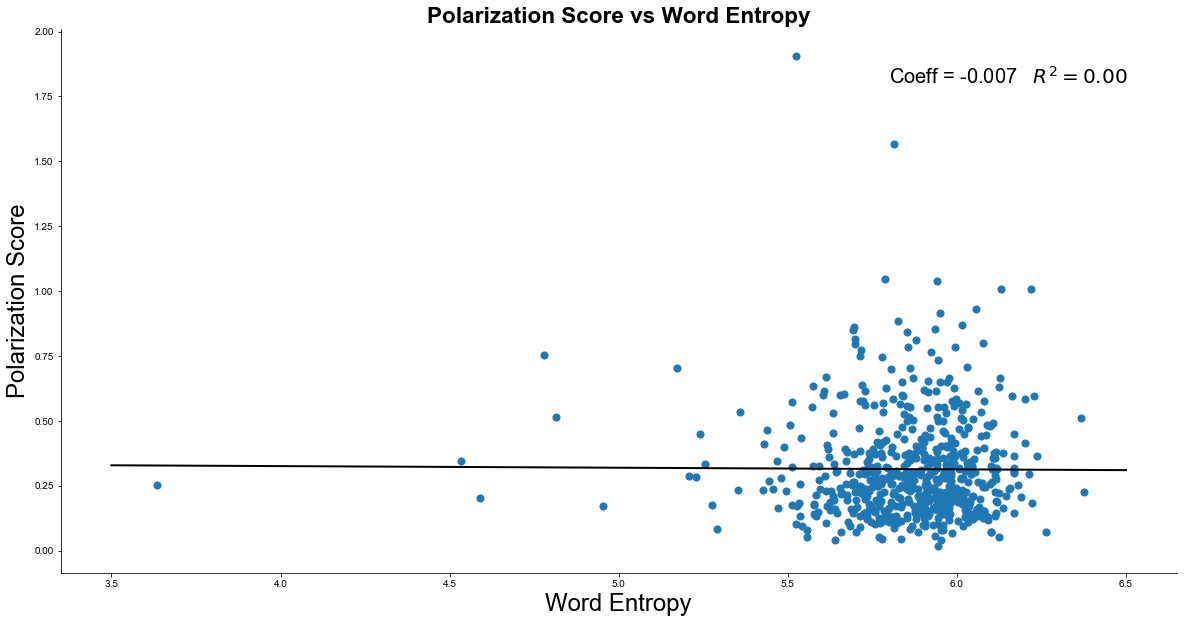

In [880]:
from scipy import stats
import statsmodels.formula.api as smf
#Convert word entropy and polarization score columns into lists
enthropy_list = result_df['Word_Entropy'].tolist()
pol_score_list = result_df['Polarization_Score'].tolist()
#Calculate correlation value
corr =np.corrcoef(pol_score_list, enthropy_list)
#Set font size for graphs
font_size = 15  

#Create model
realdata_model = smf.ols(formula = 'Polarization_Score ~ Word_Entropy', data = result_df)
realdata_result = realdata_model.fit()
realdata_result.summary()
#Get trendline slope from model
k = realdata_result.params['Word_Entropy']
#Get Rsquared value from model
Rsqr = realdata_result.rsquared

#Plot scattergraph
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(enthropy_list, pol_score_list, s=50)

#Add labels and title
ax.set_xlabel('Word Entropy', fontsize = 1.6 * font_size)
ax.set_ylabel('Polarization Score', fontsize = 1.6 * font_size)
plt.title('Polarization Score vs Word Entropy', fontsize = font_size*1.5, fontweight='bold')
#Turn off the spines
for axis in ['top','right']:
    ax.spines[axis].set_visible(False)
    
#Add trendline
real_x = np.linspace(3.5, 6.5, 616)
real_y = k*real_x + realdata_result.params['Intercept']
plt.plot(real_x, real_y, color='black', linewidth=2)
#Add text with correlation value and Rsquared value
plt.text(5.8, 1.8,'Coeff = %0.3f   $R^2 = %0.2f$'% (corr[0][1],Rsqr), fontsize=20)
#Save figure
plt.savefig('PolvsEnt.png')

In [881]:
import matplotlib
#Get a dictionary with the average word enthropy per readability score
readability_enthropy_dict = {}
count_dict = {}
#Iterate through rows in result dataframe
for i in range(len(result_df)):
    #Gather readability score and word entropy
    readability_score = result_df.iloc[i,3]
    word_enthropy = result_df.iloc[i,4]
    if readability_score > 9: #Eliminate outlier
        continue
    else:
        #Get total word entropy per readability score and the amount of data points in that readability score
        if readability_score in readability_enthropy_dict:
            readability_enthropy_dict[readability_score] += word_enthropy
            count_dict[readability_score] += 1
        else:
            readability_enthropy_dict[readability_score] = word_enthropy
            count_dict[readability_score] = 1

#Get average word enthropy
#Iterate through readability scores
for score in readability_enthropy_dict.keys():
    word_enthropy_total = readability_enthropy_dict[score]
    num = count_dict[score]
    #Calculate average
    readability_enthropy_dict[score] = word_enthropy_total/num

#Make results into lists
readability_score_lst = []
for score in readability_enthropy_dict.keys():
    readability_score_lst.append(score)
    
word_enthropy_average = []
for score in readability_enthropy_dict.keys():
    word_enthropy_average.append(readability_enthropy_dict[score])



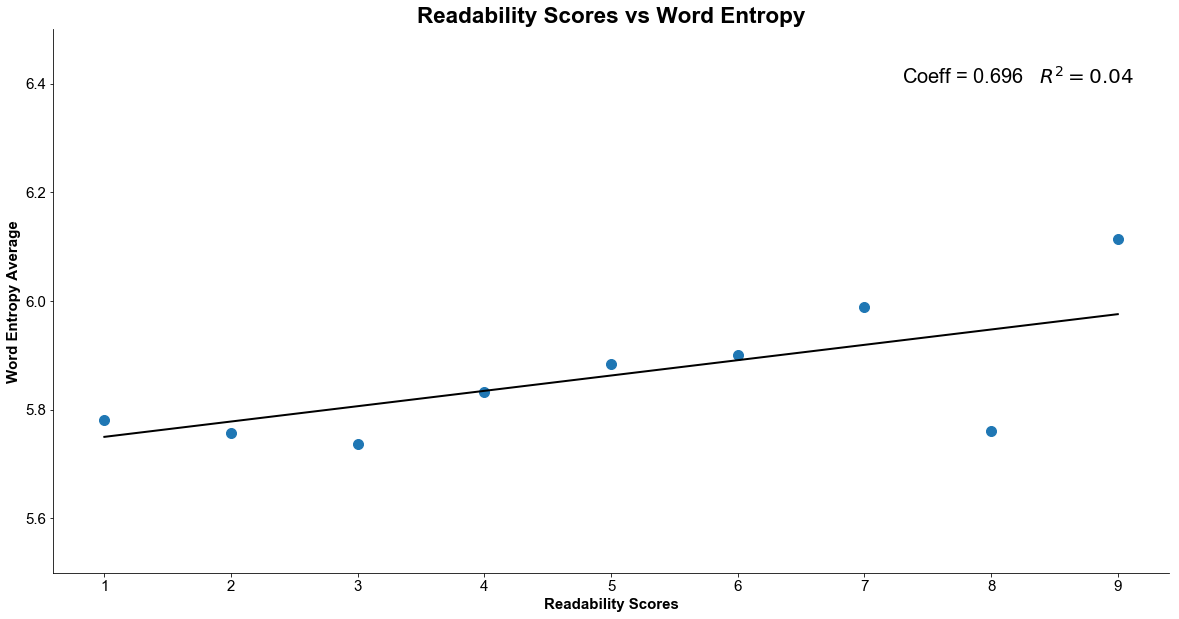

In [882]:
#Create Model
realdata_model = smf.ols(formula = 'Word_Entropy ~ Standard_Readability_Score', data = result_df)
realdata_result = realdata_model.fit()
realdata_result.summary()
#Get slope of trendline
k = realdata_result.params['Standard_Readability_Score']
#Get Rsquared value
Rsqr = realdata_result.rsquared

#Plot
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(readability_score_lst, word_enthropy_average, s=100)

#Labels and limits
plt.ylim((5.5,6.5))
plt.title('Readability Scores vs Word Entropy', fontsize = font_size*1.5, fontweight='bold')
plt.ylabel('Word Entropy Average', fontsize = font_size, fontweight='bold')
plt.xlabel('Readability Scores', fontsize = font_size, fontweight='bold')
plt.xticks(readability_score_lst, fontsize = font_size)
plt.yticks(fontsize = font_size)
#Turn off the spines
for axis in ['top','right']:
    ax.spines[axis].set_visible(False)

#Get correlation value
corr = np.corrcoef(readability_score_lst, word_enthropy_average)
#Plot trendline
real_x = np.linspace(1, 9, 19)
real_y = k*real_x + realdata_result.params['Intercept']
plt.plot(real_x, real_y, color='black', linewidth=2)
#Insert text with correlation value and Rsquared value
plt.text(7.3, 6.4,'Coeff = %0.3f   $R^2 = %0.2f$'% (corr[0][1],Rsqr), fontsize=20)
#Save figure
plt.savefig('ReadvsEnt.png')

In [883]:
#Get a dict with the total polarization score per readability score
readability_polarization_dict = {}
count_dict = {}
#Iterate through rows in result dataframe
for i in range(len(result_df)):
    #Get polarization score and readability score
    polarization_score = result_df.iloc[i,2]
    readability_score = result_df.iloc[i,3]
    if readability_score > 9: #Eliminate outlier
        continue
    else:
        #Create dictionaries that have the total polarization score per readability score and 
        #the amount of data points per readability score
        if readability_score in readability_polarization_dict:
            readability_polarization_dict[readability_score] += polarization_score
            count_dict[readability_score] += 1
        else:
            readability_polarization_dict[readability_score] = polarization_score
            count_dict[readability_score] = 1

#Iterate through readability scores
for score in readability_polarization_dict.keys():
    #Get average polarization score per readability score
    polarization_score_total = readability_polarization_dict[score]
    num = count_dict[score]
    readability_polarization_dict[score] = polarization_score_total/num
    
#Make results into lists  
polarization_score_average = []
for score in readability_polarization_dict.keys():
    polarization_score_average.append(readability_polarization_dict[score])


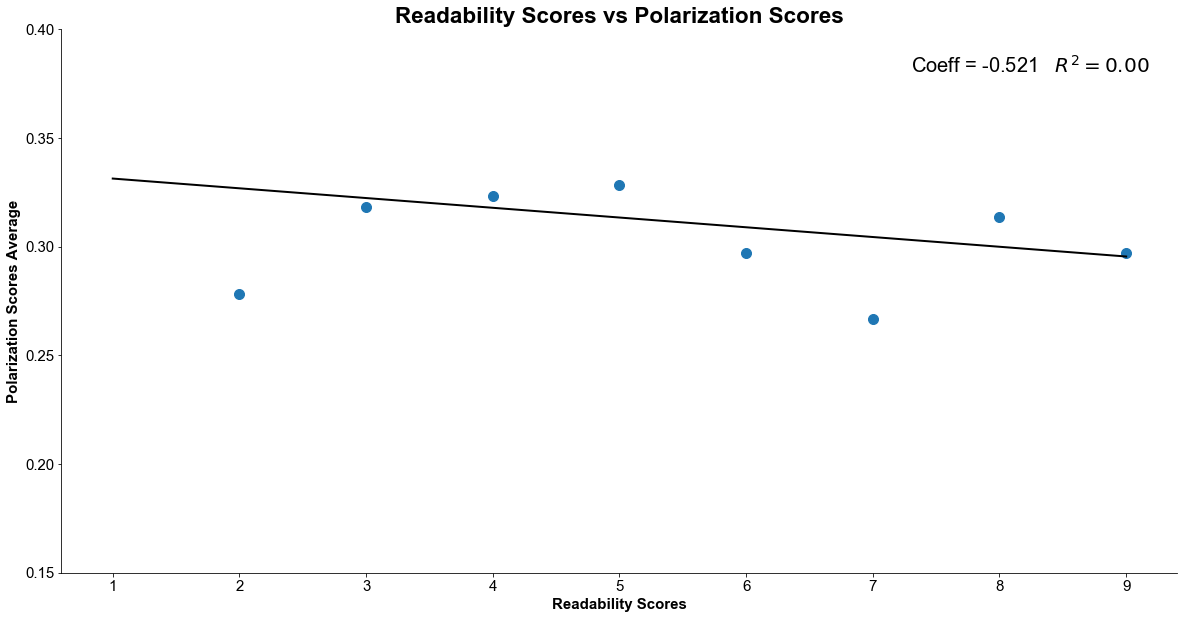

In [884]:
#Create Model
realdata_model = smf.ols(formula = 'Polarization_Score ~ Standard_Readability_Score', data = result_df)
realdata_result = realdata_model.fit()
realdata_result.summary()
#Get trendline slope
k = realdata_result.params['Standard_Readability_Score']
#Get Rsquared value
Rsqr = realdata_result.rsquared

#Plot scatter graph
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(readability_score_lst, polarization_score_average, s=100)

#Labels and limits
plt.ylim((0.15,0.4))
plt.title('Readability Scores vs Polarization Scores', fontsize = font_size*1.5, fontweight='bold')
plt.ylabel('Polarization Scores Average', fontsize = font_size, fontweight='bold')
plt.xlabel('Readability Scores', fontsize = font_size, fontweight='bold')
plt.xticks(readability_score_lst, fontsize = font_size)
plt.yticks(fontsize = font_size)
#Turn off the spines
for axis in ['top','right']:
    ax.spines[axis].set_visible(False)

#Get correlation value
corr = np.corrcoef(readability_score_lst, polarization_score_average)
#Plot trendlines
real_x = np.linspace(1, 9, 19)
real_y = k*real_x + realdata_result.params['Intercept']
plt.plot(real_x, real_y, color='black', linewidth=2)
#Insert text with correlation value and Rsquared value
plt.text(7.3, 0.38,'Coeff = %0.3f   $R^2 = %0.2f$'% (corr[0][1],Rsqr), fontsize=20)
#Save figure
plt.savefig('PolvsRead.png')

In [885]:
#Look at data per genre
import numpy
#Get the dictionary that contains the genres and the movie ids of the movies within those genres
genre_movie_dct = genre_movie_dict()

genre_data_dict = {}
genre_std_dict = {}
#Iterate through genres
for genre in genre_movie_dct.keys():
    #Get list of movie ids within the genre
    movie_lst = genre_movie_dct[genre]
    total_word_enthropy = []
    total_polarization_score = []
    total_readability_score = []
    #Iterate through movie ids
    for movie_id in movie_lst:
        #Get data from result dataframe of the movie id
        polarization_score = result_df[result_df['Movie ID'] == movie_id].iloc[0,2]
        readability_score = result_df[result_df['Movie ID'] == movie_id].iloc[0,3]
        word_enthropy = result_df[result_df['Movie ID'] == movie_id].iloc[0,4]
        #Add data to lists
        total_word_enthropy.append(word_enthropy)
        total_polarization_score.append(polarization_score)
        total_readability_score.append(readability_score)
        
    #Calculate averages of the data gathered from a genre    
    avg_word_enthropy = numpy.mean(total_word_enthropy)
    avg_polarization_score = numpy.mean(total_polarization_score)
    avg_readability_score = numpy.mean(total_readability_score)
    #Calculate standard deviation of the data from a genre
    std_dev_ent = numpy.std(total_word_enthropy)
    std_dev_pol = numpy.std(total_polarization_score)
    std_dev_read = numpy.std(total_readability_score)
    
    #Add average and standard deviation to separate dictionaries
    genre_data_dict[genre] = [ avg_word_enthropy, avg_polarization_score, avg_readability_score]
    genre_std_dict[genre] = [ std_dev_ent, std_dev_pol, std_dev_read]
    
          

In [886]:
#Create lists to plot averages using bar graphs
genre_list = []
ent_list = []
pol_list = []
read_list = []
#Iterate through genres
for i in sorted (genre_data_dict.keys()):
    #Change name to make more presentable
    if i == 'Science Fiction':
        genre_list.append('Sci-Fi')
        #Add data to lists
        ent_list.append(genre_data_dict[i][0])
        pol_list.append(genre_data_dict[i][1])
        read_list.append(genre_data_dict[i][2])
    else:
        #Add data to lists
        genre_list.append(i)
        ent_list.append(genre_data_dict[i][0])
        pol_list.append(genre_data_dict[i][1])
        read_list.append(genre_data_dict[i][2])

#Create list to plot standard deviations
std_ent_list = []
std_pol_list = []
std_read_list = []
#Iterate through genres
for i in sorted (genre_std_dict.keys()):
    #Add data to lists
    std_ent_list.append(genre_std_dict[i][0])
    std_pol_list.append(genre_std_dict[i][1])
    std_read_list.append(genre_std_dict[i][2])

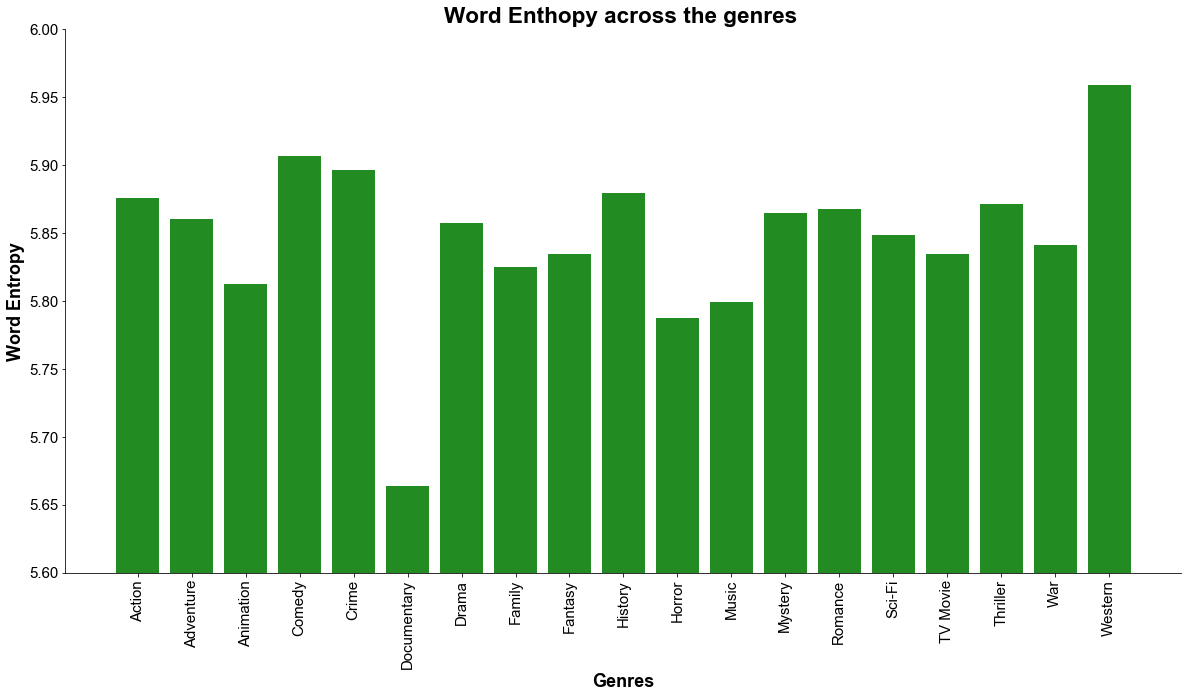

In [887]:
#Plot bar graphs
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.bar(genre_list, ent_list,color ='forestgreen')#, yerr = std_ent_list)

#Labels and limits
plt.ylim((5.6,6))
plt.title('Word Enthopy across the genres ', fontsize = font_size*1.5, fontweight='bold')
plt.ylabel('Word Entropy',fontsize = font_size*1.2, fontweight='bold')
plt.xlabel('Genres',fontsize = font_size*1.2, fontweight='bold')
plt.xticks(genre_list, rotation=90, fontsize = font_size)
plt.yticks(fontsize = font_size)
#Turn off the spines
for axis in ['top','right']:
    ax.spines[axis].set_visible(False)
#Save figure
plt.savefig('Genres_Ent')

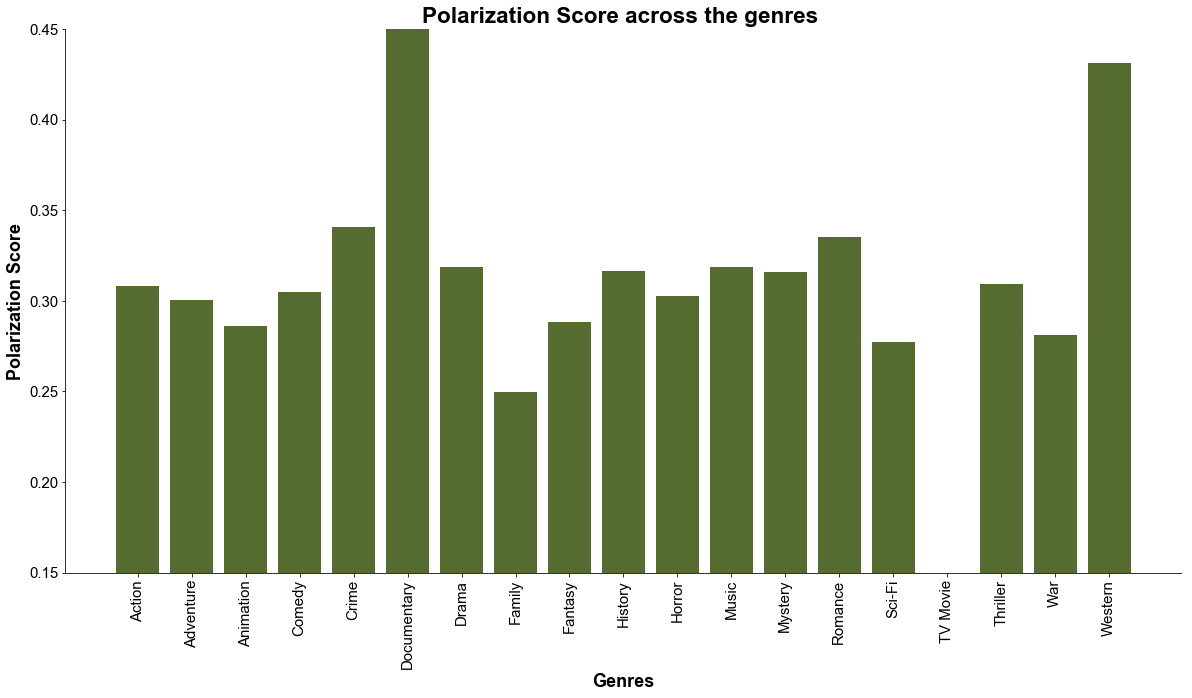

In [888]:
#Plot bar graph
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.bar(genre_list, pol_list, color ='darkolivegreen')#,yerr = std_pol_list)

#Labels and limits
plt.ylim((0.15,0.45))
plt.title('Polarization Score across the genres ', fontsize = font_size*1.5, fontweight='bold')
plt.ylabel('Polarization Score', fontsize = font_size*1.2, fontweight='bold')
plt.xlabel('Genres', fontsize = font_size*1.2, fontweight='bold')
plt.xticks(genre_list,rotation=90, fontsize = font_size)
plt.yticks(fontsize = font_size)
#Turn off the spines
for axis in ['top','right']:
    ax.spines[axis].set_visible(False)
#Save figure
plt.savefig('Genres_Pol')

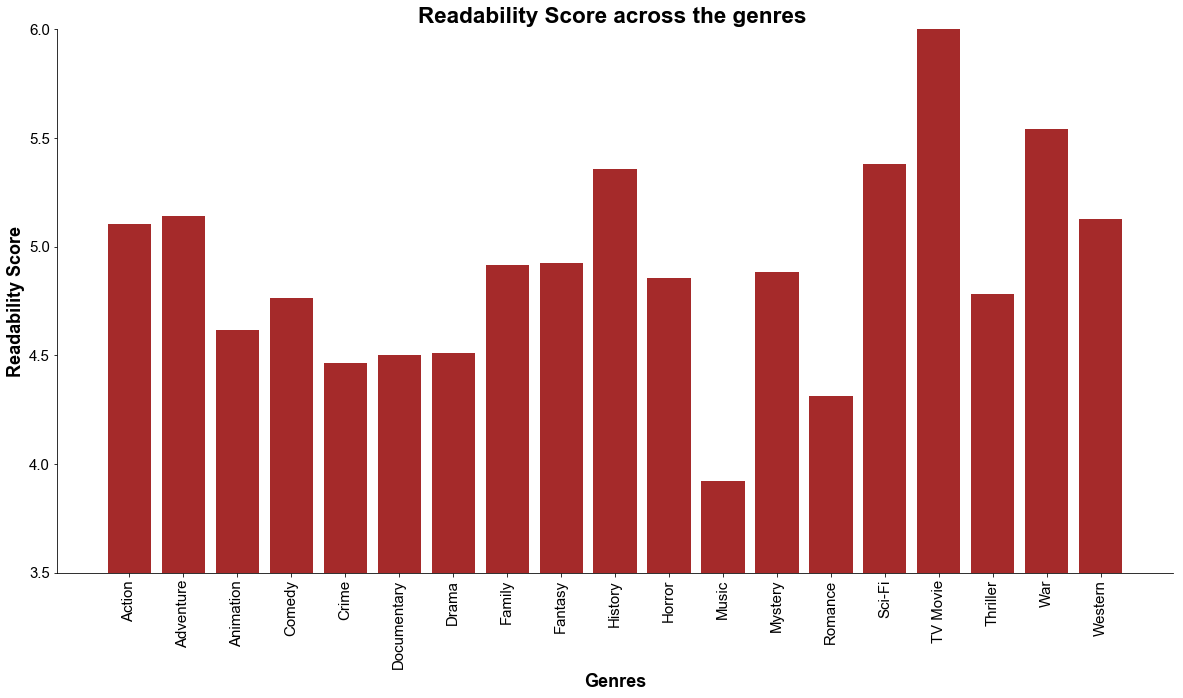

In [889]:
#Plot bar graphs
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.bar(genre_list, read_list,color='brown')#yerr = std_read_list)

#Labels and limits
plt.ylim((3.5,6))
plt.title('Readability Score across the genres ', fontsize = font_size*1.5, fontweight='bold')
plt.ylabel('Readability Score', fontsize = font_size*1.2, fontweight='bold')
plt.xlabel('Genres', fontsize = font_size*1.2, fontweight='bold')
plt.xticks(genre_list, rotation=90, fontsize = font_size )
plt.yticks(fontsize = font_size)
#Turn off the spines
for axis in ['top','right']:
    ax.spines[axis].set_visible(False)
#Save figure
plt.savefig('Genres_Read.png')